In [1]:
from utils.utils import read_dataset
from utils.explanations import calculate_cam_attributions
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os 
import tensorflow.keras as keras
from utils.explanations import minmax_norm

### Load data 

In [2]:
sorted_ts = {}
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'Coffee'
data_source = 'original'
ylen = 1
xtrain,ytrain,xtest,ytest= read_dataset(data_p, archive, dataset_name,  data_source, ylen)[dataset_name]
data_source = 'fcn_raw'
ylen = len(xtrain[0])

for ys in np.unique(ytest): 
    sorted_ts[f"{ys}"] = np.where(ytest==ys)


data = read_dataset(data_p, archive, dataset_name,  data_source, ylen)[dataset_name]
x_train, y_train, x_test, y_test  = data
print(len(x_test[0]))

classifier = 'fcn_mt_ae_0.5'
root_dir = f"G:/Meine Ablage/master thesis/code/xai-tsc"
archive_name = "ucr"
result_folder = classifier
data_source = "fcn_raw_mse"
model_path  = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/{dataset_name}/fcn/fcn_mt_ae_0.5/fcn_raw_mse/"
loaded_model = keras.models.load_model(model_path + f'best_model.hdf5' ,compile=False)
idx = 1

attributions = calculate_cam_attributions(root_dir, archive_name, result_folder, dataset_name, data_source)[idx]

286


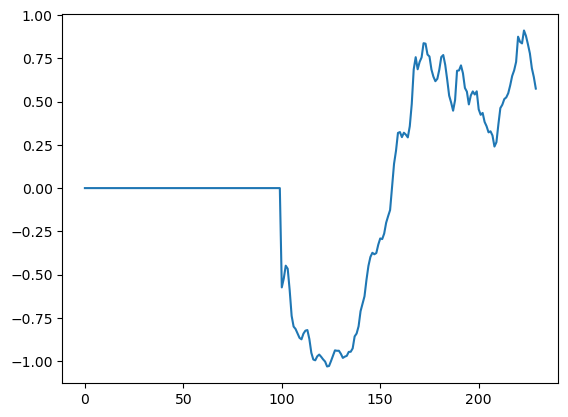

In [31]:
#Just for showcasing differnt types: 
#plt.plot(np.concatenate((np.zeros(100).astype(np.float64),x[ts1][:130].astype(np.float64))))

1/1 [==============================] - 1s 685ms/step


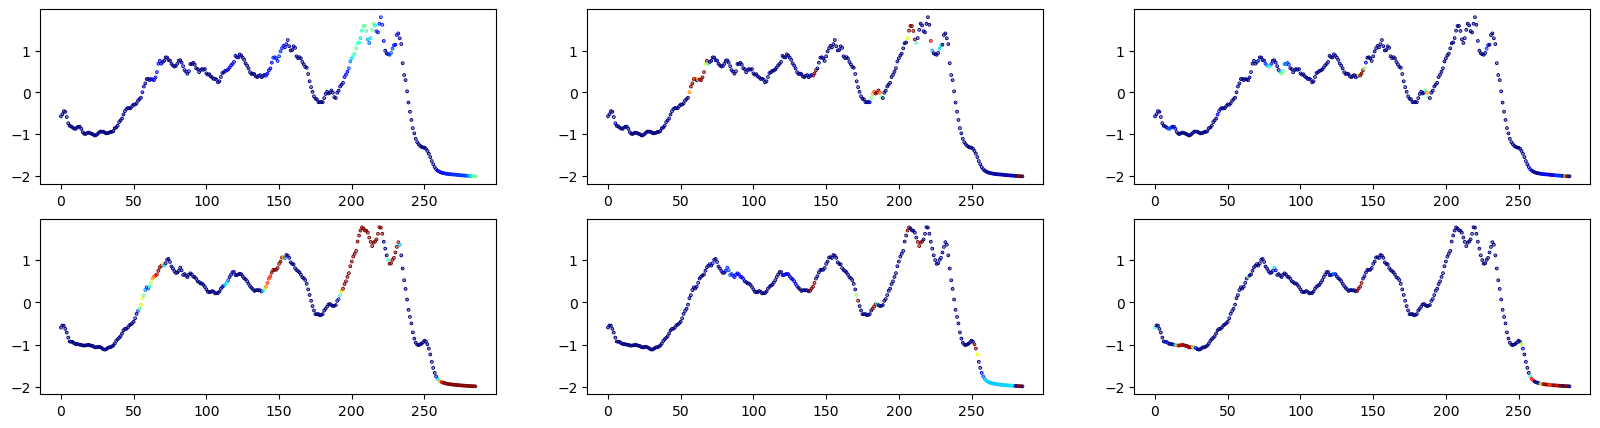

<Figure size 640x480 with 0 Axes>

In [3]:
%matplotlib inline
#%matplotlib notebook
#Split by class
#print(sorted_ts)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))
fig = plt.gcf()
x = x_test
y_pred = loaded_model.predict(x)
ts1 = 0
ts2 = 1
# Class 1: 
axes[0][0].scatter(np.arange(len(x[ts1])),x[ts1],c=attributions[ts1][2].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=10, linewidths=2.0)
axes[0][1].scatter(np.arange(len(x[ts1])),x[ts1],c=y_test[ts1].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=10, linewidths=2.0)
#axes[0][2].scatter(np.arange(len(x[ts1])),x[ts1],c=minmax_norm(attributions[ts1][2]),cmap='jet', marker='.', s=2, vmin=0, vmax=1, linewidths=2.0)
axes[0][2].scatter(np.arange(len(x[ts1])),x[ts1],c=y_pred[1][ts1].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=10, linewidths=2.0)
#Class 2: 
axes[1][0].scatter(np.arange(len(x[ts2])),x[ts2],c=attributions[ts2][2].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=1, linewidths=2.0)
axes[1][1].scatter(np.arange(len(x[ts2])),x[ts2],c=y_test[ts2].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=1, linewidths=2.0)
#axes[1][2].scatter(np.arange(len(x[ts2])),x[ts2],c=minmax_norm(attributions[ts2][2]),cmap='jet', marker='.', s=2, vmin=0, vmax=1, linewidths=2.0)
axes[1][2].scatter(np.arange(len(x[ts2])),x[ts2],c=y_pred[1][ts2].flatten(),cmap='jet', marker='.', s=2, vmin=0, vmax=1, linewidths=2.0)
#plt.plot(x_test[15])
plt.show()
plt.draw()

plt.savefig("G:/Meine Ablage/master thesis/code/xai-tsc/test_runs/Testrun_05_09_2023/Gunpoint_example_raw.png", 
            bbox_inches='tight',
            dpi=100)




In [17]:
from utils.constants import CAM_LAYERS
from scipy.interpolate import interp1d
import sklearn 
from utils.explanations import get_layer_index


classifier = "resnet_1.0"
data_source = "original"
archive_name = 'ucr'
dataset_name = 'Coffee'
x_train = xtrain
y_train = ytrain


def viz_cam(root_dir,  archive_name, classifier, dataset_name, data_source):

    max_length = 2000
    save_name = dataset_name 

    #load original data 
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    #load model 
    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'
    
    model = keras.models.load_model(model_path ,compile=False)
    
    #get gap and output layer
    gap = CAM_LAYERS[classifier.split("_")[0]]["gap_layer"]
    gap = get_layer_index(model, gap)
    out = CAM_LAYERS[classifier.split("_")[0]]["task_1"]
    out = get_layer_index(model, out)

            
    w_k_c = model.layers[out].get_weights()[0]  # weights for each filter k for each class c
    print(w_k_c.shape)

    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[gap].output, model.layers[out].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)

    #[conv_out, predicted] = new_feed_forward([ts])
    

    classes = np.unique(y_train)

    for c in classes:
        plt.figure()
        count = 0
        print(np.where(y_train == c)[0])
        c_x_train = x_train[np.where(y_train == c)[0]]
        for ts in c_x_train:
            ts = ts.reshape(1, -1, 1)
            #print(ts.shape)
            [conv_out, predicted] = new_feed_forward([ts])
            pred_label = np.argmax(predicted)
            orig_label = np.argmax(enc.transform([[c]]))
            if pred_label == orig_label:
                cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
                for k, w in enumerate(w_k_c[:, orig_label]):
                    cas += w * conv_out[0, :, k]
                
                minimum = np.min(cas)

                cas = cas - minimum

                cas = cas / max(cas)
                cas = cas * 100
                #print(ts.shape[1],ts.shape[1] - 1)
                x = np.linspace(0, ts.shape[1] - 1, max_length, endpoint=True)

                print(0, ts.shape[1] - 1, max_length)
                # linear interpolation to smooth
                f = interp1d(range(ts.shape[1]), ts[0, :, 0])

                print(range(ts.shape[1]), ts[0, :, 0].shape)
                y = f(x)
                # if (y < -2.2).any():
                #     continue
                f = interp1d(range(ts.shape[1]), cas)
                cas = f(x).astype(int)
                plt.scatter(x=x, y=y, c=cas, cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
                if dataset_name == 'Gun_Point':
                    if c == 1:
                        plt.yticks([-1.0, 0.0, 1.0, 2.0])
                    else:
                        plt.yticks([-2, -1.0, 0.0, 1.0, 2.0])
                count += 1

        cbar = plt.colorbar()
        # cbar.ax.set_yticklabels([100,75,50,25,0])
        plt.savefig(root_dir + '/results/' + classifier + '-cam-' + save_name + '-class-' + str(int(c)) + '.png',
                    bbox_inches='tight', dpi=1080)
        
viz_cam(root_dir,  archive_name, classifier, dataset_name, data_source)

(128, 2)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)


C:\Users\boent\AppData\Local\Temp\ipykernel_42960\1662734869.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)
0 285 2000
range(0, 286) (286,)


NameError: name 'y_pred' is not defined

In [10]:
classifier = "resnet_mt_dense_0.75"
data_source = "resnet_raw_mse"
archive_name = 'ucr'
dataset_name = 'Coffee'
x_train = xtrain
y_train = ytrain

#,xtest,ytest=

#G:\Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\fcn\fcn_1.0\original
# G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee/fcn/fcn_1.0/fcn_original/best_model.hdf5
print(root_dir,  archive_name, classifier, dataset_name, data_source)
def vizualise(root_dir,  archive_name, classifier, dataset_name, data_source):
    model_path  = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/{archive}/{dataset_name}/{classifier.split('_')[0]}/{classifier}/{data_source}/"
    loaded_model = keras.models.load_model(model_path + f'best_model.hdf5' ,compile=False)
    idx = 1
    y_pred = loaded_model.predict(x_train)[1]
    #print(y_pred)
    max_length = 2000
    save_name = dataset_name + '_' + data_source
    classes = np.unique(y_train)
    print(classes)
    for c in classes:
        plt.figure()
        count = 0
        print(np.where(y_train == c)[0])
        c_x_train = x_train[np.where(y_train == c)[0]]
        for idx, ts in enumerate(c_x_train): 
            #print("SHAPE", y_pred)#,ts.shape[0])
            x = np.linspace(0, ts.shape[0] - 1, max_length, endpoint=True)
            # linear interpolation to smooth
            f = interp1d(range(ts.shape[0]), ts)
            y = f(x)
            # if (y < -2.2).any():
            #     continue
            #print("WHERE",np.where(y_train == c)[0][idx])
            #print(len(range(ts.shape[0])),y_pred[38].flatten().shape)

            cas = y_pred[np.where(y_train == c)[0][idx]].flatten()

            minimum = np.min(cas)

            cas = cas - minimum

            cas = cas / max(cas)
            cas = cas * 100

            f = interp1d(range(ts.shape[0]),cas )
            cas = f(x).astype(int)
            print(cas)
            plt.scatter(x=x, y=y, c=cas, cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
        cbar = plt.colorbar()

        # cbar.ax.set_yticklabels([100,75,50,25,0])
        plt.savefig(root_dir + '/results/' + classifier + '-cam-' + save_name + '-class-' + str(int(c)) + '.png',
                    bbox_inches='tight', dpi=1080)
        

vizualise(root_dir,  archive_name, classifier, dataset_name, data_source)

G:/Meine Ablage/master thesis/code/xai-tsc ucr resnet_mt_dense_0.75 Coffee resnet_raw_mse
1/1 [==============================] - 0s 363ms/step
[0. 1.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[90 90 90 ... 95 95 94]
[92 92 91 ... 96 95 95]
[90 90 89 ... 94 94 93]
[92 92 92 ... 96 96 96]
[84 84 84 ... 89 88 88]
[92 92 92 ... 96 96 95]
[92 92 92 ... 95 95 95]
[91 91 91 ... 95 95 94]
[88 88 88 ... 92 92 91]
[89 89 89 ... 94 94 93]
[90 90 90 ... 93 93 92]
[87 87 87 ... 91 91 91]
[90 90 90 ... 94 94 94]
[91 91 91 ... 94 94 93]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
[95 95 95 ... 90 91 91]
[67 67 67 ... 64 64 64]
[93 93 93 ... 89 89 89]
[87 87 87 ... 83 83 84]
[90 90 91 ... 86 87 87]
[97 97 97 ... 92 93 93]
[86 86 86 ... 83 83 83]
[90 90 90 ... 87 87 87]
[94 94 94 ... 91 91 91]
[88 88 88 ... 84 85 85]
[93 93 93 ... 89 90 90]
[87 88 88 ... 84 84 84]
[92 93 93 ... 88 88 89]
[92 92 92 ... 88 89 89]
